In [23]:
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
load_dotenv()
import os
import datetime

API_KEY = os.getenv("API_KEY")

# Run these commands when accessing your virtualenv
# virtualenv yt-data-script 
# source yt-data-script/bin/activate
# yt-data-script/bin/pip3 install google-api-python-client

DONE: A Youtube scrapper that gives information for trending videos (THE SCRAPER WORKS NOW!)

DONE: Use all of the data and then create a WordCloud involving tags or commonly used words in video titles for certain YouTube video categories

Next Feature: Be able to get data from certain searches (let's say a user 'searches' for minecraft let's play, what is commonly seen in their titles?)

Next Feature: Be able to get 50 videos based upon most viewed, etc. from a certain YouTube channel creator

**Thought: What about the recommended videos, how do I get info about these?

Next Feature: Run the information through a machine learning model for each video section that will then try to create a YouTube title based off of the data, try this for the lolz (one thing though, it's going to need, A LOT OF DATA per section)

Next Feature: Add in support for looking a certain YT creators YT channel, to see how their videos perform

Potential Feature: OAuth support for more detailed statstics for a user's own channel

Potential Feature: Create a web app that shows the video thumbnails, along with the statistics such as tags, likes, dislikes, comments, view count

** In regards to the machine learning model **
You should set up the script to collect data over the course of a couple of days to gain more data, and figure out a way to remove duplicates


In [8]:
youtube = build('youtube', 'v3', developerKey=API_KEY)

request = youtube.videos().list(
    part='snippet',
    chart='mostPopular',
    maxResults = 50
)

request2 = youtube.videoCategories().list(
    part='snippet',
    regionCode='US'
)

request3 = youtube.videos().list(
    part='statistics',
    chart='mostPopular',
    maxResults = 50
)
request4 = youtube.videos().list(
    part='snippet'
)

request5 = youtube.search().list(
    part='snippet',
    maxResults=50,
    type='video',
    q='modded minecraft' # query to search for, you can change this to whatever you want
)

vidInfo = request.execute() # Holds top 50 trending video info
catInfo = request2.execute() # Holds category info
ratingInfo = request3.execute() # Holds rating info
searchInfo = request5.execute() # Holds 50 video search results based upon a keyword

youtube.close()

In [37]:
# Items in snippet:
# publishedAt, channelId, title, description, thumbnails, channelTitle, tags, categoryId, liveBroadcastContent, localized

# Stores the top 50 trending video titles in a list
# Index 0 being the #1 trending video

def infoReturn(response: tuple, maxResults: int, type:str, info: str):
    # IDEA: COULD THIS FUCNTION BE EDITIED TO WORK WITH MORE THAN JUST TOP 50 TRENDING?
    '''Returns an array with information related to the info input'''
    # Needs a part 'snippet' or a 'statistics' response tuple
    trendTitle = []
    for i in range(maxResults):
        if info in list(response['items'][i][type]):
            trendTitle.append(response['items'][i][type][info]) # Will break if a field is empty
        else:
            trendTitle.append("N/A")
    return trendTitle

def idToNameConvDict(response: tuple):
    '''Creates a dictionary that holds the ids for categories'''
    # Needs the category id and region id
    CatIdToCatName = {}
    for i in range(len(catInfo['items'])):
        CatIdToCatName.update({catInfo['items'][i]['id']: catInfo['items'][i]['snippet']['title']})
    return CatIdToCatName

def catIdToName(catId: dict, idArray: list):
    '''Converts a category ID array into a an array with category names'''
    catNameArray = []
    for i in range(len(catIdArray)):
        catNameArray.append(catDict[catIdArray[i]])
    return catNameArray

# The next thing to do would be to put combine each attribute into a list or dictionary for each video
# So basically making a prettier JSON file, wow lol
# Or maybe make a class which holds this info and make like fifty objects?

# Could be something like the following:
# Ranking (this is based off of the index)
# Video Title
# Description (maybe use this info to see what the most common words are in each description depending on the category ID)
# Category ID
# Views
# Likes
# Dislikes
# Maybe a ratio for likes and dislikes
# Comment data

class VideoInfo:
    def __init__(self, ranking: int, title: list, description: list, channelTitle: list = None, catName: list = None,  
        views: list = None, likes: list = None, dislikes: list = None, comments: list = None):
        # VideoInfo constructor
        self._ranking = ranking
        self._channelTitle = channelTitle
        self._title = title
        self._description = description
        self._catName = catName
        self._views = views
        self._likes = likes
        self._dislikes = dislikes
        self._comments = comments
        # can add in a ratio
    
    def getRanking(self):
        return self._ranking

    def getTitle(self):
        return self._title
    
    def getDescription(self):
        return self._description

    def getChannelTitle(self):
        return self._channelTitle

    def getCatName(self):
        return self._catName

    def getViews(self):
        return self._views

    def getLikes(self):
        return self._likes

    def getDislikes(self):
        return self._dislikes
    
    def getComments(self):
        return self._comments

In [38]:
# Extracting all of the information into lists
# Is there a way to extract the file name of a video, that also helps in algorithm effectiveness

catDict = idToNameConvDict(catInfo) # Holds the ids for category name

titleArray = infoReturn(vidInfo, 50, 'snippet', 'title') # Holds the title trending array
catIdArray = infoReturn(vidInfo, 50, 'snippet', 'categoryId') # Holds the categoryId information
tagArray = infoReturn(vidInfo, 50, 'snippet', 'tags') # Holds tags for each video
descArray = infoReturn(vidInfo, 50, 'snippet', 'description') # Holds description for each video
channelNameArray = infoReturn(vidInfo, 50, 'snippet','channelTitle') # Holds channel names
thumbnailArray = infoReturn(vidInfo, 50, 'snippet','thumbnails') # Holds thumbnail links, needs more parsing
viewsArray = infoReturn(ratingInfo, 50, 'statistics', 'viewCount') # Holds viewcount
likeArray = infoReturn(ratingInfo, 50, 'statistics', 'likeCount') # Holds like count
dislikeArray = infoReturn(ratingInfo, 50, 'statistics', 'dislikeCount') # Holds dislike count
commentArray = infoReturn(ratingInfo, 50, 'statistics', 'commentCount') # Holds comment count
catNameArray = catIdToName(catDict, catIdArray) # Holds the name of each category id

In [39]:
vidClass = []
# Makes an array that holds 50 video objects
for i in range(50):
    videoClass = VideoInfo(i+1, titleArray[i], descArray[i], channelNameArray[i],
    catNameArray[i], viewsArray[i], likeArray[i], dislikeArray[i], commentArray[i])
    vidClass.append(videoClass)

In [56]:
# Magic related to the search results
# keys: publishedAt, channelId, title, description, thumbnails, channelTitle, liveBroadcastContent, publishTime
searchTitleArray = infoReturn(searchInfo, 50, 'snippet', 'title')
searchDescArray = infoReturn(searchInfo, 50, 'snippet', 'description')
searchChannelNameArray = infoReturn(searchInfo, 50, 'snippet', 'channelTitle')
searchThumbnailArray = infoReturn(searchInfo, 50, 'snippet', 'thumbnails')

Analysis and Machine Learning Time!

,Channel Title,Title,Description,Category Name
1,Ceeday,Chapter 3 No Way Home,Chapter 3 No Way Home use my support a creato...,Gaming
2,Mrwhosetheboss Shorts,The STUPIDEST smartphone cases EVER,Do consider subscribing to my Shorts Channel! ...,Science & Technology
3,JonTronShow,Watching the Most Disliked Videos - JonTron,Install Raid for Free ✅ Mobile and PC: and g...,Comedy
4,Safiya Nygaard,I Ran A Boba Tea Shop For A Day,HELLO FRIENDS!! A portion of this video was pr...,People & Blogs
5,Kai Cenat,How To Die In Every Hood!,MERCH: Sure You keep Up With All Of My Social...,Entertainment
6,MeatCanyon,Behind Dreams Mask,Thanks for watching :) if you enjoyed the vide...,Film & Animation
7,Tommy Zhang,I think I need more friends #shorts,This game is called Joking Hazard. Made by the...,Entertainment
8,Jeenie.Weenie,MY TOP LIP SYNC TIKTOK OF 2021: ✨ZADDY✨,,Comedy
9,The Military Show,Marines Surprise WWII Veteran,Watch as Marines surprise this World War Two v...,Science & Technology
10,BradMartin_,POV Design Your Soulmate... GONE WRONG (Part 11),#shorts #povHey Rad Fam! Thanks for watching!!...,Entertainment


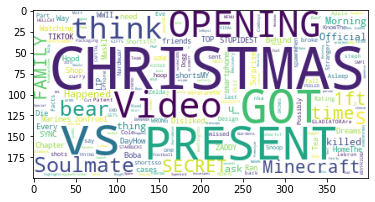

In [76]:
import emoji
import re
from wordcloud import WordCloud, STOPWORDS

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def cleanData(text):
    '''Removes emojis, links, and \n from text'''
    text = text.strip()
    text = re.sub("\n","", text)
    text = re.sub("\r","", text)
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE) # not removing https things?
    return text

# Use modules such as the WordCloud, NLTK, spaCy, and others to process the most common words
# Try separating these words based upon the categories they exists, pandas should help with this!
df = pd.DataFrame(columns = ['Channel Title', 'Title', 'Description', 'Category Name'])

# Have to remove emojis from text strings
# PLEASE ADD IN THUMBNAIL SUPPORT FOR YOUR REACT IDEA!
# FOR THAT IDEA MAKE SURE TO HOLD ON TO THE ORIGINAL NAMES PRIOR TO CLEANING THE DATA
for i in range(50):
    title = cleanData(vidClass[i].getTitle()) # cleans text
    description = cleanData(vidClass[i].getDescription())
    catName = vidClass[i].getCatName()
    channelTitle = vidClass[i].getChannelTitle()
    df = df.append({'Channel Title': channelTitle, 'Title': title, 
        'Description': description, 'Category Name': catName}, ignore_index = True)

df.index += 1
currDate = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
df.to_csv('yt-trending-data-' + currDate + '.csv')

megaString = ""

for i in range(50):
    megaString = megaString + df['Title'].iloc[i]


wordcloud = WordCloud(random_state=1, stopwords= STOPWORDS, background_color = 'white').generate(megaString)

#wordCloud = WordCloud().generate_from_frequencies(df['Description'])
plt.imshow(wordcloud)
df

In [77]:
seaClass = []
# Makes an array that holds 50 video objects
for i in range(50):
    searchClass = VideoInfo(i+1, searchTitleArray[i], searchDescArray[i], searchChannelNameArray[i],
    None, None, None, None, None)
    seaClass.append(searchClass)

df2 = pd.DataFrame(columns = ['Channel Title', 'Title', 'Description'])
# Have to remove emojis from text strings
for i in range(50):
    title = seaClass[i].getTitle() # cleans text
    description = seaClass[i].getDescription()
    channelTitle = seaClass[i].getChannelTitle()
    df2 = df2.append({'Channel Title': channelTitle, 'Title': title, 
        'Description': description}, ignore_index = True)

# For some reason the last index overwrites everything in the frame

df2.index += 1
currDate = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
# Figure out a way to have the query just pop up in the file name or somewhere
# Right now the query is 'modded minecraft'
df2.to_csv('yt-search-data-' + currDate + '.csv')

df2

,Channel Title,Title,Description
1,EthosLab,Etho&#39;s Modded Minecraft S2 #1: Beautiful N...,Welcome everyone to Season 2 of Etho's Modded ...
2,Welsknight Gaming,Minecraft Modded Survival Returns! | Create: A...,"Let's play Create: Above and Beyond, a Minecra..."
3,Gaming On Caffeine,Minecraft Cave Factory | A NEW GENERATION OF S...,Minecraft Cave Factory | A NEW GENERATION OF S...
4,Waffles,I Survived 100 Days in Hardcore Ultra Modded M...,I Spent 100 Days in Hardcore Minecraft I Spent...
5,ChosenArchitect,Better Minecraft EP1 What Minecraft Should Hav...,Welcome to Better Minecraft! Ever wanted Minec...
6,fWhip,Better Minecraft : Cottagecore STARTER HOUSE E...,fWhip is playing Modded Minecraft with Better ...
7,ButterJaffa,100 DAYS WITH 500 MODS!?! | Minecraft - 500 Mo...,"Hey guys and welcome to Greedycraft, the BIGGE..."
8,CyberFuel Studios,Cave Factory Modpack | BEST STONEBLOCK MODPACK...,BEST STONEBLOCK MODPACK? Cave Factory EP1 | Mo...
9,Joshemve,I Spent 100 Days in 1.17 HARDCORE MODDED Minec...,I Spent 100 Days in HARDCORE MODDED Minecraft ...
10,ChosenArchitect,All the Mods 6 To the Sky EP1 New Modded Minec...,All the mods are taking their feet off of the ...
